In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplearning/dataset_WL_CW_Y.npy
/kaggle/input/deeplearning/dataset_WL_CW_X.npy


In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as scio
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
try:
    import mne
    print("mne is already installed")
except ModuleNotFoundError:
    !pip install mne
try:
    import ipywidgets
    print("ipywidgets is already installed")
except ModuleNotFoundError:
    !pip install ipywidgets
from ipywidgets import interact, widgets
from scipy.signal import welch
import pandas as pd

mne is already installed
ipywidgets is already installed


In [4]:
#Load data in
file_path = '/kaggle/input/deeplearning/dataset_WL_CW_X.npy'
file_path = '/kaggle/input/deeplearning/dataset_WL_CW_Y.npy'

#your_data_array = np.load(file_path)
X = np.load('/kaggle/input/deeplearning/dataset_WL_CW_X.npy')
X2 = np.load('/kaggle/input/deeplearning/dataset_WL_CW_X.npy')
label = np.load('/kaggle/input/deeplearning/dataset_WL_CW_Y.npy')
label2 = np.load('/kaggle/input/deeplearning/dataset_WL_CW_Y.npy')
print(X.shape)
print(label.shape)
print(label)

(62, 512, 360)
(1, 360)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [5]:


if label2.shape[0] != 2:
  label2 = np.zeros((2, 360))
  label2[0, :] = label[0, :]
  label2[1, :] = 1 - label[0, :]
  print(label2[:, :15])
  print(label2.shape)
else:
  print("Label already changed \n",label2.shape, "\n",label2[:, :312])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(2, 360)


In [6]:
X_2 = X.reshape(62 * 512, 360)

In [7]:
import numpy as np
from scipy import stats


class EEGFeatureExtractor:
    """
    Extracts time-domain and connectivity features from multi-channel EEG data.
    """

    def __init__(self):
        """
        Initializes feature names.
        """
        self.feature_names = [
            "Mean",
            "Standard deviation",
            "Skewness",
            "Kurtosis",
            "Mean upper triangle correlation",
        ]

    def get_time_domain_features(self, X, sample_idx):
        """
        Calculates time-domain features for each channel in a given EEG sample.

        Args:
            X (np.ndarray): A 3D NumPy array of shape (channels, time_points, samples) representing the EEG data.
            sample_idx (int): Index of the sample for which to calculate features.

        Returns:
            np.ndarray: A 2D NumPy array of shape (channels, 4) containing the calculated features for each channel.
        """

        features = np.zeros((X.shape[0], 4))
        sample_data = X[:, :, sample_idx]

        for channel_idx in range(X.shape[0]):
            channel_data = sample_data[channel_idx, :]
            features[channel_idx, 0] = np.mean(channel_data)  # Mean
            features[channel_idx, 1] = np.std(channel_data)  # Standard deviation
            features[channel_idx, 2] = stats.skew(channel_data)  # Skewness
            features[channel_idx, 3] = stats.kurtosis(channel_data)  # Kurtosis

        return features

    def get_connectivity_features(self, X, sample_idx):
        """
        Calculates connectivity features for a given EEG sample.

        Args:
            X (np.ndarray): A 3D NumPy array of shape (channels, time_points, samples) representing the EEG data.
            sample_idx (int): Index of the sample for which to calculate features.

        Returns:
            np.ndarray: A 1D NumPy array of shape (channels,) containing the mean upper triangle correlation for each channel.
        """

        sample_data = X[:, :, sample_idx]
        corr_matrix = np.corrcoef(sample_data)

        if not hasattr(np, 'triu_indices_n'):
            def triu_indices_n(n, k=0):
                m = n - k
                return np.triu_indices(n, k=k), np.triu_indices(m, k=k)

        if hasattr(np, 'triu_indices_n'):
            corr_triu = corr_matrix[np.triu_indices_n(X.shape[0], k=1)]  # Extract upper triangle (efficiently for newer NumPy)
        else:
            corr_triu = corr_matrix[np.triu_indices(X.shape[0], k=1)[0]]  # Extract upper triangle (compatible with older NumPy)

        # Handle potential division by zero
        if np.all(corr_triu == corr_triu[0]):
            corr_triu = np.ones_like(corr_triu)

        # Reshape and calculate mean across the second dimension
        corr_triu = corr_triu.reshape(62, -1).mean(axis=1)
        return corr_triu

    def calculate_features(self, X):
        """
        Orchestrates the calculation of both time-domain and connectivity features.

        Args:
            X (np.ndarray): EEG data in a 3D array (channels, time_points, samples).

        Returns:
            np.ndarray: Extracted features organized as (channels, features_per_channel, samples).
        """

        features = np.zeros((X.shape[0], len(self.feature_names), X.shape[2]))

        for sample_idx in range(X.shape[2]):
            # Efficiently leverage individual feature extraction functions:
            time_domain_features = self.get_time_domain_features(X, sample_idx)
            connectivity_features = self.get_connectivity_features(X, sample_idx)

            # Combine features into a cohesive output array:
            features[:, :4, sample_idx] = time_domain_features  # Assign time-domain features
            features[:, 4, sample_idx] = connectivity_features  # Assign connectivity feature

        return features

    def get_feature_names(self):
        """
        Returns the list of feature names in the order they appear in the output.
        """
        return self.feature_names



#Use from X2 or X
extractor = EEGFeatureExtractor()
features = extractor.calculate_features(X2)
feature_names = extractor.get_feature_names()

#print("Feature names:", feature_names)
print(features.shape)
print(feature_names,"\n", features[:5, :, 0])  # Print all features for the first sample
features = features.reshape(62 * 5, 360)

(62, 5, 360)
['Mean', 'Standard deviation', 'Skewness', 'Kurtosis', 'Mean upper triangle correlation'] 
 [[ 1.77070343 10.91615582  0.19657676 -0.07511581  0.58574443]
 [ 0.54546785 11.20091057  0.15481508 -0.20793333  0.58531177]
 [-1.64428246 16.36531067 -0.2433497  -0.11014821  0.66535506]
 [ 3.79236603 15.1456461  -0.18992012  0.12326339  0.65949174]
 [-0.9406004  11.10280037  0.4340974   0.0637624   0.49331928]]


# Logistic Regression with feature engineering

(310, 360)


/tmp/ipykernel_34/2963673707.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Gradient check: Relative difference = 1.189491
Fold 1/5 - Validation Accuracy: 0.5000, Final Loss: -0.011305
Gradient check: Relative difference = 0.854505
Fold 2/5 - Validation Accuracy: 1.0000, Final Loss: -2.395356
Gradient check: Relative difference = 1.264325
Fold 3/5 - Validation Accuracy: 0.5000, Final Loss: 0.270032
Gradient check: Relative difference = 0.790971
Fold 4/5 - Validation Accuracy: 0.0000, Final Loss: -0.037759
Gradient check: Relative difference = 0.840705
Fold 5/5 - Validation Accuracy: 0.5000, Final Loss: -3.419877
Average Accuracy: 0.5000
Sample classifications:


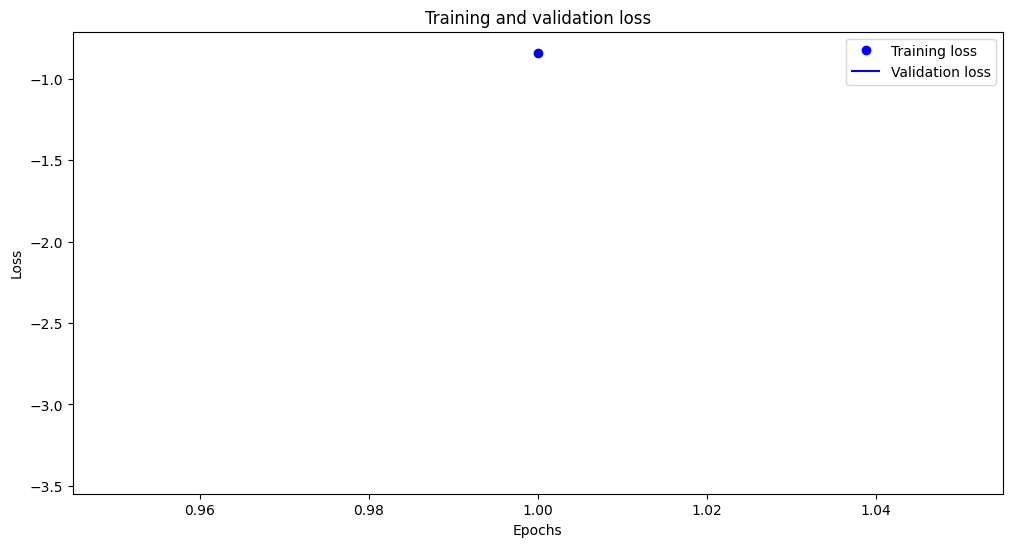

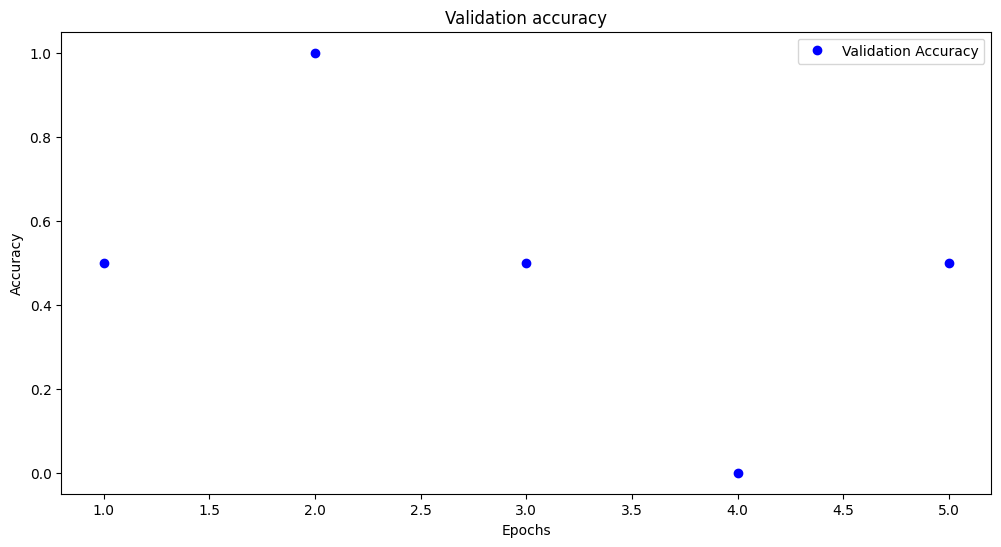

In [12]:
import numpy as np
from tqdm import tqdm
import pickle

def classify(input_data, workload_labels):
    probabilities = softmax(model.predict(input_data))
    predicted_labels = np.argmax(probabilities, axis=0)
    classifications = [workload_labels[label] for label in predicted_labels]
    return classifications


# Data normalization function
def normalize_data(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    return (data - mean) / (std + 1e-8)  # Add a small constant to avoid division by zero

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)  # Converts True/False to 1/0

def sigmoid_derivative(x):
    return x * (1 - x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / (np.sum(e_x, axis=0, keepdims=True) + 1e-8)  # Add a small constant to avoid division by zero

def binary_cross_entropy_gradient(y_true, y_pred):
    eps = 1e-2  # Add a small epsilon to avoid division by zero
    y_pred = np.clip(y_pred, eps, 1 - eps)  # Clip predictions to avoid overflow
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + eps)  # Add epsilon to denominator

class BasicNN_train:
    def __init__(self, input_size, num_classes, batch_size, num_epochs, k):
        self.epoch = num_epochs
        self.k = k
        self.input_size = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.w00 = np.random.rand(self.input_size, self.num_classes) * 0.001  # Initialize weights with small random values
        self.b00 = np.zeros((self.num_classes, 1))  # Initialize biases with zeros
        self.loss_history = []

    def forward(self, input_data):
        input_to_n00_sigmoid = np.zeros((self.num_classes, input_data.shape[1]))
        num_cols = input_data.shape[1]
        for col in range(num_cols):
            input_to_n00_sigmoid[:, col] = self.w00.T @ input_data[:, col] + self.b00[:, 0]  # Calculate for each column

        n00_sigmoid_output = sigmoid(input_to_n00_sigmoid)
        return n00_sigmoid_output

    def backward(self, input_data, output_data, lr):
        y_pred = self.forward(input_data)
        g_pred = binary_cross_entropy_gradient(output_data, y_pred)

        # Calculate gradient of predictions w.r.t. linear combination (sigmoid derivative)
        g_linear = g_pred * sigmoid_derivative(y_pred)

        # Calculate gradient of linear combination w.r.t. weights
        g_W_gradient = np.dot(g_linear, input_data.T) / input_data.shape[0]  # Normalize gradient by batch size
        self.w00 -= lr * g_W_gradient.T

        # Calculate gradient of linear combination w.r.t. biases
        g_b_gradient = g_linear.mean(axis=1, keepdims=True)

        # Gradient clipping for biases (optional)
        clip_value = 1.0  # Adjust the clipping threshold as needed
        g_b_gradient = np.clip(g_b_gradient, -clip_value, clip_value)

        self.b00 -= lr * g_b_gradient

        return g_W_gradient.T

    def predict(self, input_data):
        output = self.forward(input_data)
        return output

    def classify(self, input_data, workload_labels):
        probabilities = softmax(self.predict(input_data))
        predicted_labels = np.argmax(probabilities, axis=0)
        classifications = [workload_labels[label] for label in predicted_labels]
        return classifications

def check_gradients(model, X_batch, y_batch, epsilon=1e-4):
    # Check for empty batch before gradient calculations
    if X_batch.size == 0 or y_batch.size == 0:
        return

    # Get analytical gradients (from your backward pass)
    analytical_dw = model.backward(X_batch, y_batch, 0)  # Set lr to 0 for gradient calculation

    # Calculate numerical gradients
    numerical_dw = np.zeros_like(model.w00)
    for i in range(model.w00.shape[0]):
        for j in range(model.w00.shape[1]):
            # Perturb weight slightly
            model.w00[i, j] += epsilon
            loss_plus = model.forward(X_batch).mean()  # Calculate loss with perturbed weight
            model.w00[i, j] -= 2 * epsilon
            loss_minus = model.forward(X_batch).mean()  # Calculate loss with perturbed weight
            model.w00[i, j] += epsilon  # Restore original weight

            # Approximate gradient numerically
            numerical_dw[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

    # Compare gradients
    diff = np.linalg.norm(analytical_dw - numerical_dw) / np.linalg.norm(analytical_dw + numerical_dw)
    print(f"Gradient check: Relative difference = {diff:.6f}")

class DynamicLearningRateScheduler:
    def __init__(self, initial_lr, min_lr=1e-6, decay_rate=0.99):
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.decay_rate = decay_rate
        self.current_lr = initial_lr

    def get_lr(self, epoch, val_loss, prev_val_loss):
        # Decay the learning rate if the validation loss doesn't improve
        if val_loss >= prev_val_loss:
            self.current_lr *= self.decay_rate

        # Ensure the learning rate doesn't go below the minimum value
        self.current_lr = max(self.current_lr, self.min_lr)
        return self.current_lr

def train(model, X_train, y_train, X_val, y_val, batch_size, lr, early_stopping_patience, loss_threshold=0.0001, max_epochs=1000):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size
    if num_samples % batch_size != 0:
        num_batches += 1

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    patience_counter = 0
    lr_scheduler = DynamicLearningRateScheduler(lr)
    prev_val_loss = np.inf

    epoch = 0
    while epoch < max_epochs:
        epoch_train_loss = 0.0
        shuffled_indices = np.random.permutation(num_samples)
        X_train = X_train[:, shuffled_indices]
        y_train = y_train[:, shuffled_indices]

        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, num_samples)
            X_batch = X_train[:, start:end]
            y_batch = y_train[:, start:end]

            # Forward pass
            output_pred = model.forward(X_batch)

            # Calculate loss
            loss = binary_cross_entropy_gradient(y_batch, output_pred)
            epoch_train_loss += loss.mean()

            # Backward pass
            lr_current = lr_scheduler.current_lr
            model.backward(X_batch, y_batch, lr_current)

            # Gradient checking
            if epoch % 10 == 0 and batch == 0:
                check_gradients(model, X_batch, y_batch)

        # Calculate and print training loss
        epoch_train_loss /= num_batches
        train_losses.append(epoch_train_loss)

        # Calculate and print validation loss
        output_pred = model.predict(X_val)
        val_loss = binary_cross_entropy_gradient(y_val, output_pred).mean()
        val_losses.append(val_loss)

        # Update learning rate and check for early stopping
        lr_scheduler.get_lr(epoch, val_loss, prev_val_loss)
        prev_val_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                break

        # Check if the loss threshold is reached
        if val_loss <= loss_threshold:
            break

        # Print loss values
        print(f"Epoch {epoch + 1} - Train Loss: {epoch_train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {lr_scheduler.current_lr:.8f}")
        epoch += 1

    return train_losses, val_losses

def cross_validate(model, X, y, k, batch_size, num_epochs, lr, early_stopping_patience):
    num_samples = y.shape[1]
    indices = np.random.permutation(num_samples)

    accuracies = []
    for fold in range(k):
        start = int(fold * num_samples / k)
        end = int((fold + 1) * num_samples / k)
        val_idx = indices[start:end]
        train_idx = np.concatenate([indices[:start], indices[end:]])

        X_train, X_val = X[:, train_idx], X[:, val_idx]
        y_train, y_val = y[:, train_idx], y[:, val_idx]

        # Normalize data
        X_train = normalize_data(X_train)
        X_val = normalize_data(X_val)

        # Train the model
        train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, batch_size, num_epochs, lr, early_stopping_patience)

        # Evaluate on validation set
        output_pred = model.predict(X_val)
        accuracy = np.mean(np.argmax(output_pred, axis=1) == np.argmax(y_val, axis=1))
        accuracies.append(accuracy)
        print(f"Fold {fold + 1}/{k} - Validation Accuracy: {accuracy:.4f}, Final Loss: {val_losses[-1]:.6f}")

    print(f"Average Accuracy: {np.mean(accuracies):.4f}")

    # Save the trained model
    with open('trained_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    return model, train_losses, val_losses, accuracies

class LearningRateScheduler:
    def __init__(self, initial_lr, num_epochs, decay_rate=0.9):
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.num_epochs = num_epochs

    def get_lr(self, epoch):
        lr = self.initial_lr * (self.decay_rate ** (epoch // (self.num_epochs // 3)))
        return lr


Y_Tester = label2.copy()
X_Tester = features.copy()
print(X_Tester.shape)
num_classes = 2  # Only two classes: 0 (low workload) and 1 (medium workload)
input_size = X_Tester.shape[0]
batch_size = 36
num_epochs = 300
lr = 0.001
early_stopping_patience = 10
k = 5  # Number of folds
workload_labels = ["low", "medium"]  # List of workload labels

model = BasicNN_train(input_size, num_classes, batch_size, num_epochs, k)
model, train_losses, val_losses, accuracies = cross_validate(model, X_Tester, Y_Tester, k, batch_size, num_epochs, lr, early_stopping_patience)

# Classify samples after training
classifications = model.classify(X_Tester, workload_labels)
print("Sample classifications:")
#for i, classification in enumerate(classifications):
    #print(f"Sample {i + 1}: {classification}")

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, 'bo', label='Validation Accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Logistic Regression w/o feature engineering